# Chatbot with message summarization & external DB memory


In [1]:
%pip install --quiet -U langchain_groq langchain_core langgraph langgraph-checkpoint-sqlite


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.6 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
apikey = userdata.get('GROQ_API_KEY')

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model= 'llama-3.3-70b-versatile', temperature = 0, api_key=apikey)

## Sqlite


In [5]:
import sqlite3

conn = sqlite3.connect(":memory:", check_same_thread=False)

In [6]:
import sqlite3
# pull file if it doesn't exist and connect to local db

!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2025-03-03 17:52:22--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-03-03 17:52:23--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.02s   

2025-03-03 17:52:23 (4.39 MB/s) - ‘s

In [7]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory: SqliteSaver = SqliteSaver(conn)

In [9]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState


class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State) -> State:

    # Get summary if it exists
    summary = state.get("summary", "")
    print(f"Using summary: {summary}")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State) -> State:
    print(f"Messages before summarizing: {len(state['messages'])}")
    # First, we get any existing summary
    summary = state.get("summary", "")
    print(f"Existing summary: {summary}")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"


    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    # Summarization logic
    print(f"New summary: {response.content}")

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    print(f"Messages after truncation: {len(delete_messages)}")
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> State:

    """Return the next node to execute."""

    messages = state["messages"]
    print(f"Message count: {len(messages)}")
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

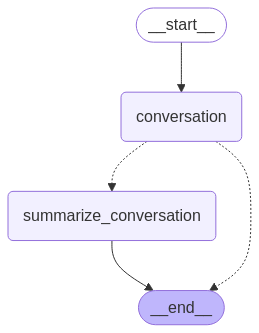

In [10]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="I would like to know about football.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: Here's a summary of the conversation:

Lance introduced himself twice during the conversation. He expressed his fondness for the San Francisco 49ers football team. The AI assistant acknowledged Lance's name each time and showed willingness to discuss the 49ers, offering to talk about various aspects of the team such as their history, current roster, or memorable games. The conversation was brief and somewhat repetitive, with Lance reintroducing himself at the end without directly responding to the AI's questions or prompts about the 49ers.
Message count: 8
Messages before summarizing: 8
Existing summary: Here's a summary of the conversation:

Lance introduced himself twice during the conversation. He expressed his fondness for the San Francisco 49ers football team. The AI assistant acknowledged Lance's name each time and showed willingness to discuss the 49ers, offering to talk about various aspects of the team such as their history, current roster, or memorable games. T

In [12]:
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: Here's an updated summary of the conversation:

Lance introduced himself twice during the conversation. He expressed his fondness for the San Francisco 49ers football team. The AI assistant acknowledged Lance's name each time and showed willingness to discuss the 49ers, offering to talk about various aspects of the team such as their history, current roster, or memorable games. The conversation was brief and somewhat repetitive, with Lance reintroducing himself at the end without directly responding to the AI's questions or prompts about the 49ers.

As the conversation progressed, Lance mentioned that he would like to know about football, which led the AI assistant to provide a general overview of the sport, including its basics, the NFL, and the 49ers. The AI assistant explained the objective of the game, the different positions, and the gameplay, in an attempt to educate Lance about football. Despite this, Lance did not engage in a detailed discussion about the 49ers o

In [13]:
input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: Here's an updated summary of the conversation:

Lance introduced himself twice during the conversation. He expressed his fondness for the San Francisco 49ers football team. The AI assistant acknowledged Lance's name each time and showed willingness to discuss the 49ers, offering to talk about various aspects of the team such as their history, current roster, or memorable games. The conversation was brief and somewhat repetitive, with Lance reintroducing himself at the end without directly responding to the AI's questions or prompts about the 49ers.

As the conversation progressed, Lance mentioned that he would like to know about football, which led the AI assistant to provide a general overview of the sport, including its basics, the NFL, and the 49ers. The AI assistant explained the objective of the game, the different positions, and the gameplay, in an attempt to educate Lance about football. Despite this, Lance did not engage in a detailed discussion about the 49ers o

In [14]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='I would like to know about football.', additional_kwargs={}, response_metadata={}, id='4f2c5b47-2665-491c-ac8c-963853129829'), AIMessage(content="Football is an exciting sport. Since you're a 49ers fan, I'll provide an overview of the game and highlight some key aspects related to the NFL and the 49ers.\n\n**The Basics:**\n\n* Football is a contact team sport played with an oval-shaped ball.\n* Two teams, each with 11 players, take turns playing offense (trying to score) and defense (trying to stop the other team from scoring).\n* The team with possession of the ball is called the offense, and they try to score by carrying or throwing the ball into the end zone of the opponent's field.\n* Points can be scored through touchdowns (6 points), field goals (3 points), or extra points (1 or 2 points).\n\n**NFL and 49ers:**\n\n* The National Football League (NFL) is the top-level professional American football league in the United State

In [15]:
config = {"configurable": {"thread_id": "1"}}
messages = graph.get_state(config).values.get("messages")
len(messages)

6

In [16]:
graph_state = graph.get_state(config).values.get("summary","")
graph_state

"Here's an updated summary of the conversation:\n\nLance introduced himself twice during the conversation. He expressed his fondness for the San Francisco 49ers football team. The AI assistant acknowledged Lance's name each time and showed willingness to discuss the 49ers, offering to talk about various aspects of the team such as their history, current roster, or memorable games. The conversation was brief and somewhat repetitive, with Lance reintroducing himself at the end without directly responding to the AI's questions or prompts about the 49ers.\n\nAs the conversation progressed, Lance mentioned that he would like to know about football, which led the AI assistant to provide a general overview of the sport, including its basics, the NFL, and the 49ers. The AI assistant explained the objective of the game, the different positions, and the gameplay, in an attempt to educate Lance about football. Despite this, Lance did not engage in a detailed discussion about the 49ers or football